# Creating a Manually Labeled Dataset

## 1. Objective

### 1.1 Why this matter?


### 1.2 What is the output of this notebook?


### 1.3 Key Takeaway and actions
- Some logs show strange behavior of temperature being stable and not cycling, unclear why
- Some logs show constant temperature readings, indicating that the unit was unplugged. That probably should be reinserted in the next pre processing phases or understood its root causes

***
## 2. Setup

Run the below code to import all the necessary libraries and data to run the following codes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection, LineCollection
from matplotlib.ticker import PercentFormatter
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas



import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

from src.RefriPlot import *
from src.RefriDataHelper import *

import warnings
warnings.filterwarnings("ignore")

DEFAULT_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] #Proposed colors, in case temp is not plotted


#Allows generated charts to be interactive
%matplotlib widget

#Read preprocessed CSVs
csv_files = RefriDataHelper_ReadParsedLogs()

#Store the name of the temp columns for further calculations
TEMP_COL_NAMES = list(csv_files.values())[0].columns[2:]

***
## 3. Analyzing Outlier Logs


### 3.1 Logs Distribution

In Order to obtain some high level summary of the temperature logs, below is a histogram of some basic statistical information of each sensors troughout all the logs on the dataset:
- Mean
- Standard Deviation
- Min and Max
- 25%(Q1), 50%(Q2) and 75%(Q3) percentiles (or quartiles). In our case it for example, a log that has RC_25% at 0°C means that 25% of it's values are below 0°C

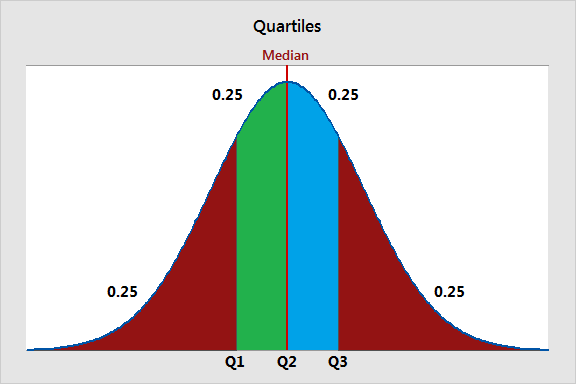

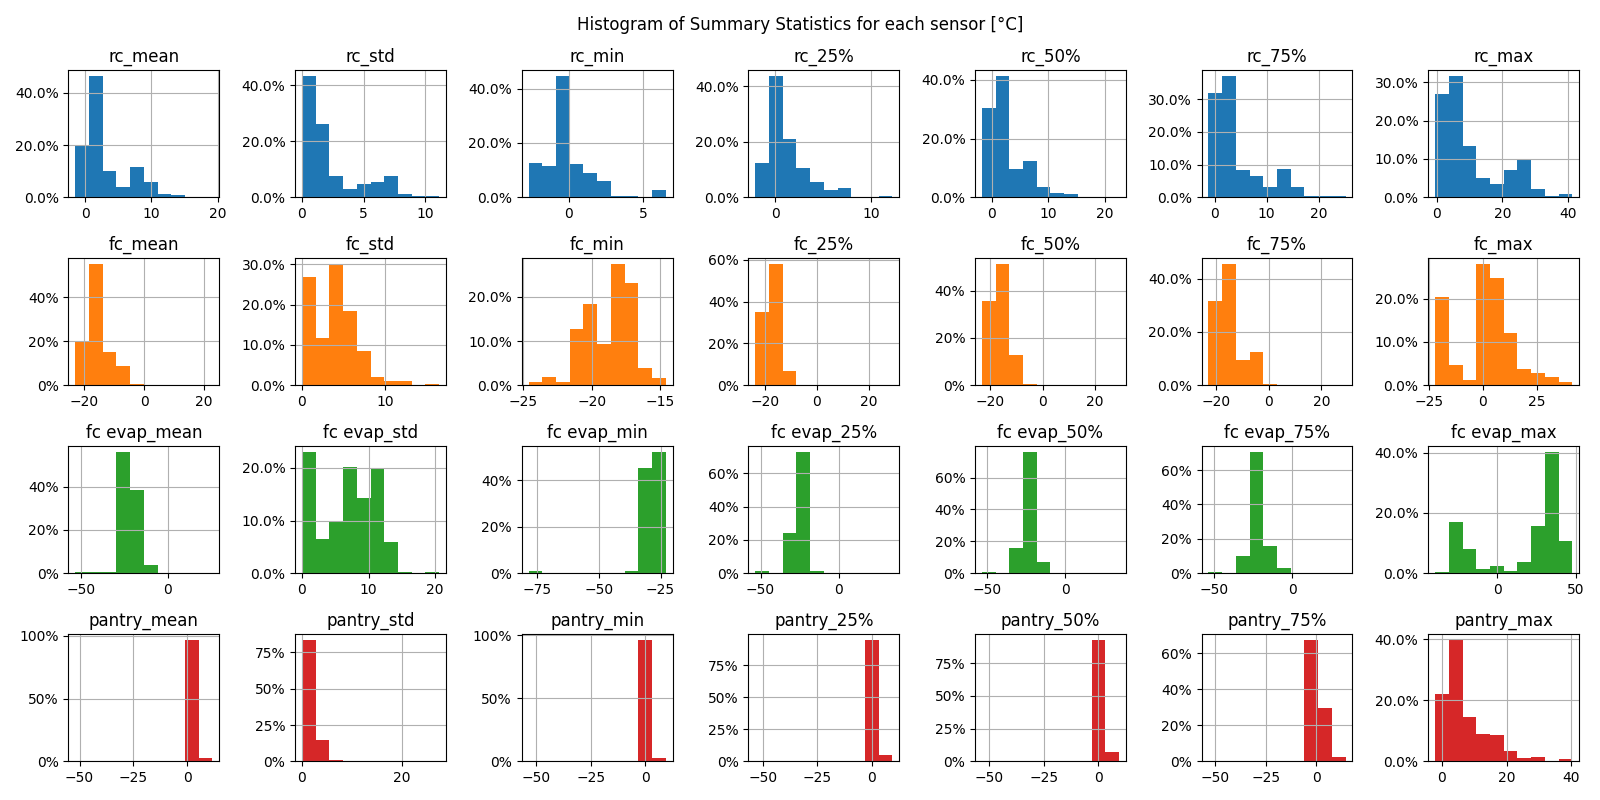

In [2]:
# Use describe method to get the overall statistics of each collumn for each log
sensors_summary = []
for log_id,log_name in enumerate(csv_files):
    sensors_summary.append([log_name])
    for sensor_name in TEMP_COL_NAMES:
        log_sensor_summary = csv_files[log_name][sensor_name].describe().to_list()
        log_sensor_summary = log_sensor_summary[1:]   #Do not include count as a valid data, as it's not relevant and will be same for all sensors
        sensors_summary[log_id].extend(log_sensor_summary)

#Create the name of the columns, which will be SENSOR_NAME + Statistic name, e.g: FC Mean, FC Max, ... RC Mean, RC Max, ...
summary_cols = csv_files[log_name][sensor_name].describe().index.to_list()[1:]

col_names = ['Log Name']
for sensor_name in TEMP_COL_NAMES:
    col_names.extend([sensor_name + '_' + s for s in summary_cols])

#Create a dataframe containing all the sensors summary by log
logs_summary = pd.DataFrame(sensors_summary,columns=col_names)
# logs_summary.to_csv("../Data/Pre_Processed/Summarized Statistics of Temperatures.csv")

#Plot a histogram of each sensor
fig_hist = plt.figure(figsize=(16, 8))
gs = fig_hist.add_gridspec(len(TEMP_COL_NAMES),len(summary_cols))    

for sensor_id,sensor_name in enumerate(TEMP_COL_NAMES):
    for col_id,col_name in enumerate(summary_cols):
            ax = fig_hist.add_subplot(gs[sensor_id, col_id])
            logs_summary.hist(column=sensor_name+"_"+col_name, ax=ax, weights=np.ones(len(logs_summary)) / len(logs_summary), color=DEFAULT_COLORS[sensor_id])  
            fig_hist.gca().yaxis.set_major_formatter(PercentFormatter(1))    #Use weights to transform and formatter to transform into percentage

fig_hist.suptitle("Histogram of Summary Statistics for each sensor [°C]")
plt.tight_layout()
plt.show()

### 3.2 Manually analyzing logs

From the upper distribution charts, we will try to manually classify and understand those logs that seem to be too far from the usual. So, in summary, let's try to manually (or partially manually) classify, or put labels on our dataset.

Initially, we will focus on defining the logs as:
- NORMAL: Logs that probably belong to a product working normally
- BAD: Logs that are either unclear of what is going on by just looking at temperature plots, or that are logs which probably the product was not plugged or something similar
- Fault: Logs that for sure seemed like one of the load was in failure

A couple interesting things can be observed by those charts:
1. There are 2 logs of Pantry Temperature with mean around -10°C (potential damper stuck open) and 11 logs of Pantry Temperature with average around 10°C (potential damper stuck close)
    
    Where by analyzing those specific cases, it was observed that some of them seem to be damper in fault, while others seems to be bad logs

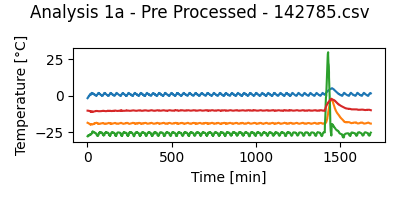

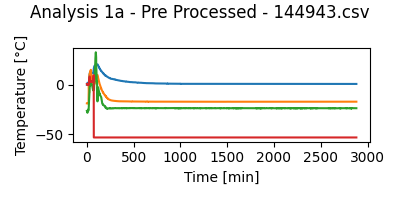

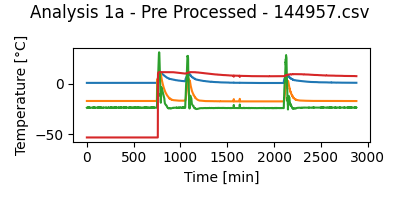

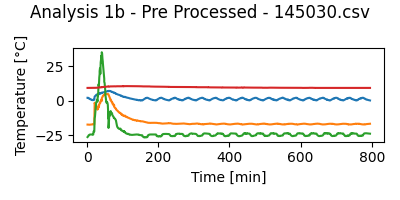

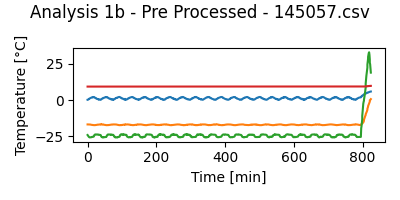

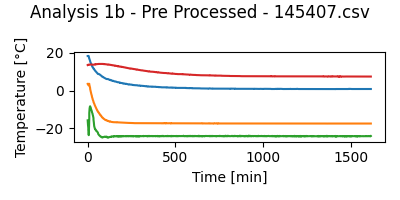

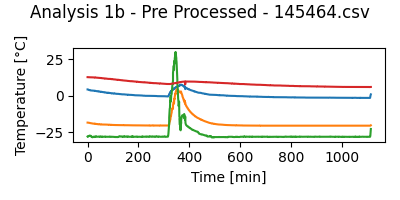

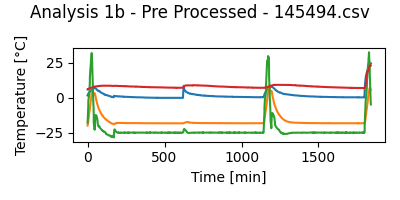

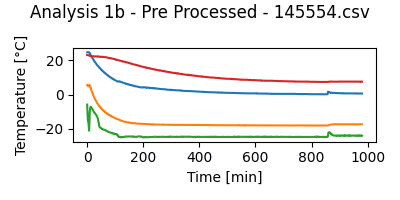

In [3]:
#Create a list of the logs that are ok. For now considering all of them ok
logs_summary['Log Label'] = "UNKNONW"


#Logs with Too cold Pantry
analysis1a = logs_summary[logs_summary['pantry_mean'] < -5]['Log Name']

for log_to_analyze in analysis1a:
    RefriPlot_PlotTemperature(csv_files[log_to_analyze],"Analysis 1a - " + log_to_analyze,fig_size=(4,2))

#Logs that showed pantry temperature as too hot, probably means no cold air has flown to it, so assuming it's a damper stuck closed
logs_summary.loc[logs_summary['Log Name']=="Pre Processed - 142785.csv", 'Log Label'] =  "FAULT - Pantry Damper Open"
logs_summary.loc[logs_summary['Log Name']=="Pre Processed - 144943.csv", 'Log Label'] =  "BAD"
logs_summary.loc[logs_summary['Log Name']=="Pre Processed - 144957.csv", 'Log Label'] =  "BAD"



#Logs with Too Hot Pantry
analysis1b = logs_summary[logs_summary['pantry_mean'] > 8]['Log Name']

for log_to_analyze in analysis1b:
    RefriPlot_PlotTemperature(csv_files[log_to_analyze],"Analysis 1b - " + log_to_analyze,fig_size=(4,2))

#Logs that showed pantry temperature as too hot, probably means no cold air has flown to it, so assuming it's a damper stuck closed
logs_summary.loc[logs_summary['Log Name']=="Pre Processed - 145030.csv", 'Log Label'] =  "FAULT - Pantry Damper Closed"
logs_summary.loc[logs_summary['Log Name']=="Pre Processed - 145057.csv", 'Log Label'] =  "FAULT - Pantry Damper Closed"

#The below logs will be considered as BAD because their temperatures do not cycle for some reason, so either this logs are bad or we currently don't have knowledge to classify them
logs_summary.loc[logs_summary['Log Name']=="Pre Processed - 145407.csv", 'Log Label'] =  "BAD"
logs_summary.loc[logs_summary['Log Name']=="Pre Processed - 145464.csv", 'Log Label'] =  "BAD"
logs_summary.loc[logs_summary['Log Name']=="Pre Processed - 145494.csv", 'Log Label'] =  "BAD"
logs_summary.loc[logs_summary['Log Name']=="Pre Processed - 145554.csv", 'Log Label'] =  "BAD"

2. There is 1 Log of FC Evap average at 25°C, potential bad log where the product was not ON, since this temperature is way too hot to be an FC Evap (probably not even compressor ON)

    After plotting the chart it was observed that indeed is a bad log with the refrigerator being unplugged and stopped to publish data.

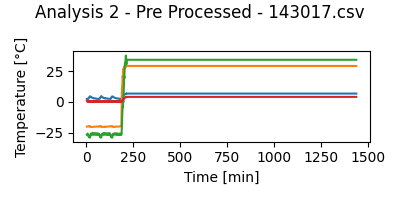

In [4]:
analysis2 = logs_summary[logs_summary['fc evap_mean'] > 10]['Log Name']

for log_to_analyze in analysis2:
    RefriPlot_PlotTemperature(csv_files[log_to_analyze],"Analysis 2 - " + log_to_analyze,fig_size=(4,2))

#Considering as bad because probably the unit got unplugged, this is why sensors read as constant value
logs_summary.loc[logs_summary['Log Name']=="Pre Processed - 143017.csv", 'Log Label'] =  "BAD"

3. There are 5 Logs of FC Evap min temperature below -50, which should indicate FC Evap Sensor in Failure, since usually those temperatures are not reached.

This point actually caught a lot the attention, since in theory the software should not even allow temperatures colder than -53.44°C according to the SettingFile

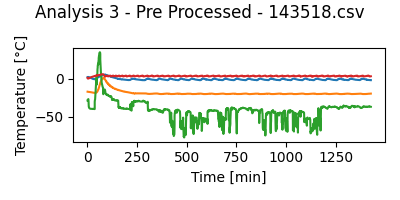

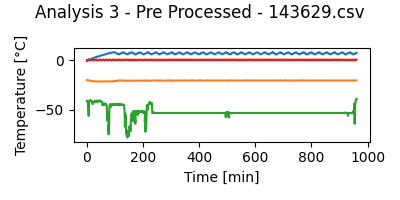

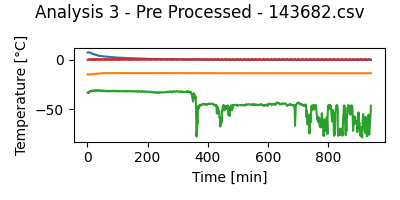

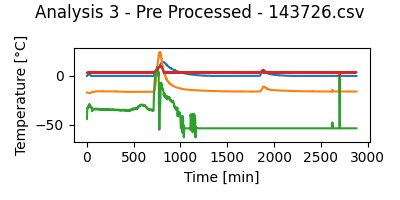

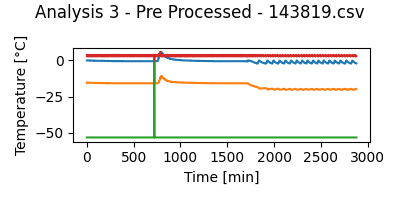

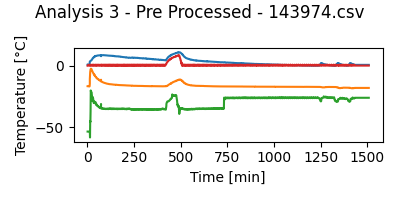

In [5]:
analysis3 = logs_summary[logs_summary['fc evap_min'] < -50]['Log Name']

for log_to_analyze in analysis3:
    RefriPlot_PlotTemperature(csv_files[log_to_analyze],"Analysis 3 - " + log_to_analyze,fig_size=(4,2))
    logs_summary.loc[logs_summary['Log Name']==log_to_analyze, 'Log Label'] =  "BAD"

4. Some logs of RC mean temperature above 9°C, which could indicate a bad log or damper in failure

But as it will be observed, all those logs are fine, but they were all logs that seemed to be of door openings

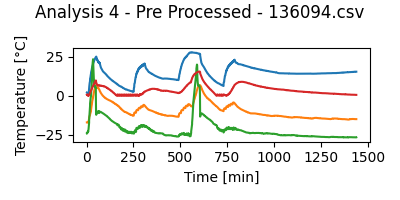

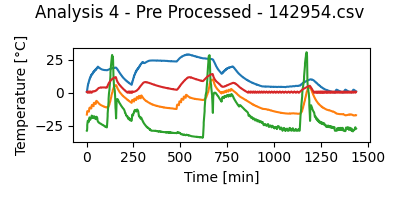

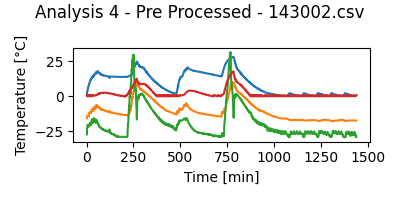

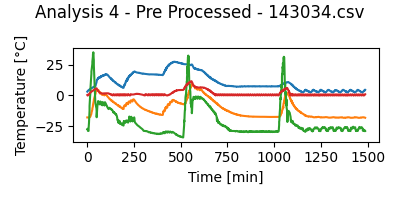

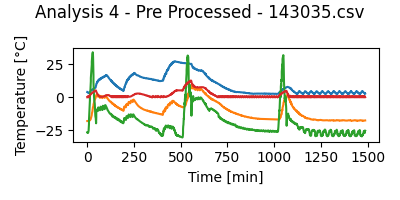

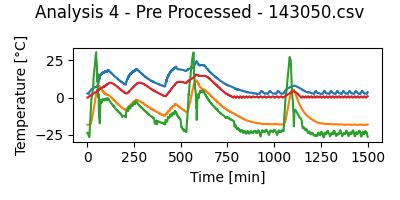

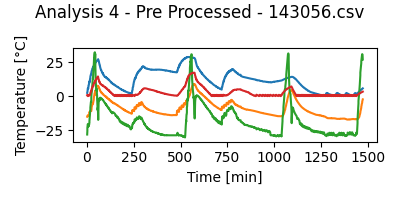

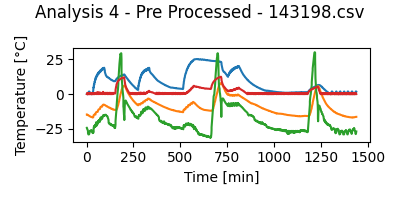

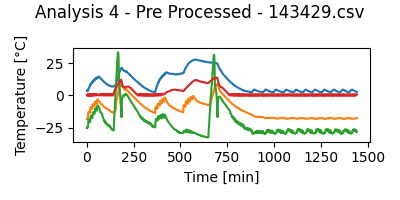

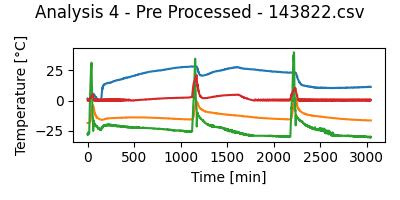

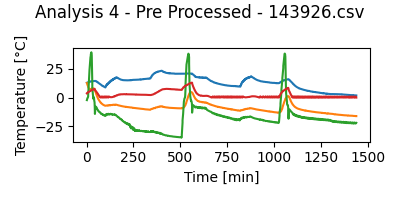

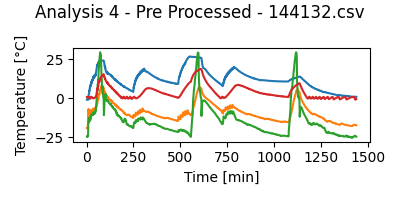

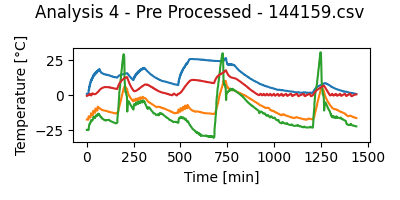

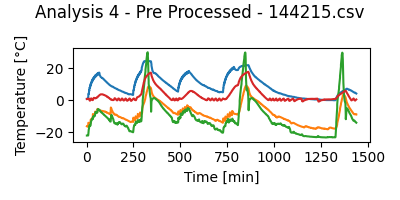

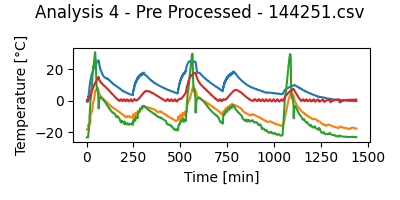

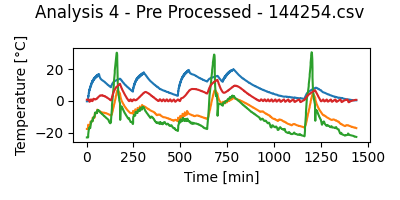

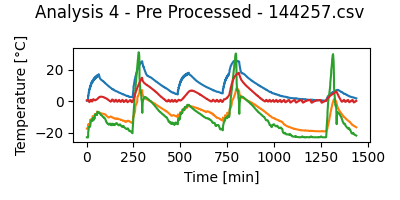

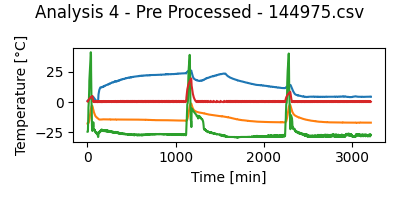

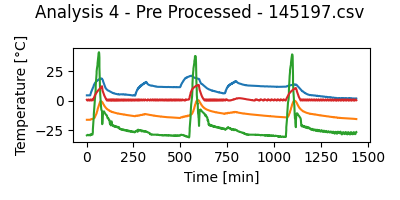

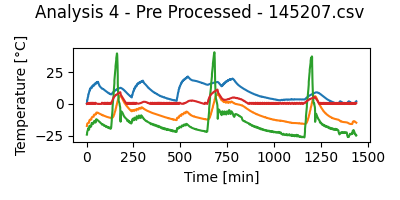

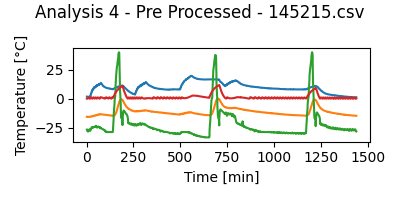

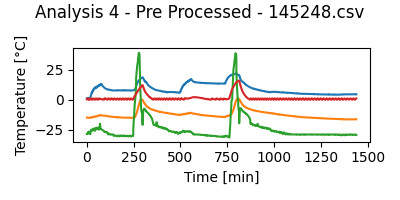

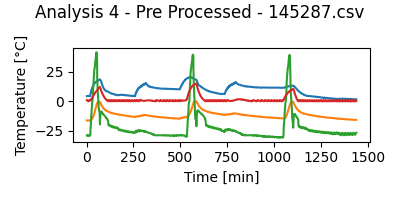

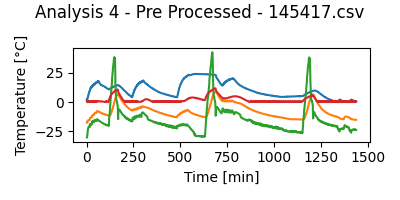

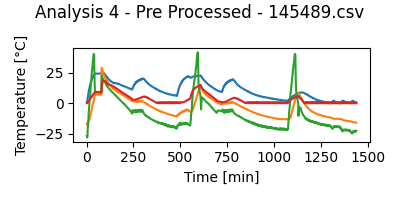

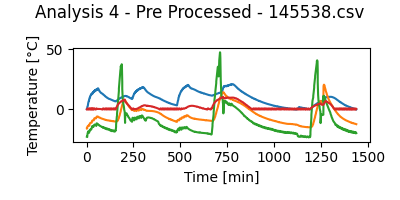

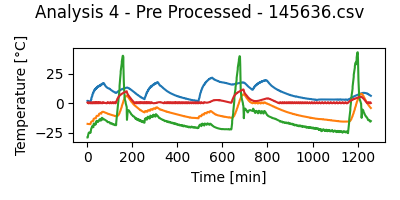

In [6]:
analysis4 = logs_summary[logs_summary['rc_mean'] > 9]['Log Name']

for log_to_analyze in analysis4:
    RefriPlot_PlotTemperature(csv_files[log_to_analyze],"Analysis 4 - " + log_to_analyze,fig_size=(4,2))

## 3.3 Modeling the problem of Outlier Detection

In order to represent the problem of temperature sensors data as a machine learning problem, it was decided at least for this specific problem of unsupervised approach, to use the representation of the time series as a vector of features and use them to train model. In this specific case, is to use the data obtained from `logs_summary` generated previously. This is because it's indeed basically vectors of the main features that describe the main characteristics of the sensors reading.

It's very important to highlight that this is one of the possible approaches to the problem, as it reduces the large data complexity that we have (4 sensors x around 1200 samples over time = 4800 values) to only 32 variables per temperature log. This is good in a certain way, but it's certainly an approach that loses the temporal nature of the data and may not capture complex patterns.


## 3.4 Using Machine Learning Isolation Forest

Isolation Forests is an unsupervised learning algorithm used for anomaly detection. The main idea behind isolation forests is that anomalies are rare and can be identified quickly by isolating them from the rest of the data. The anomaly score assigned to each data point is a measure of how easily it was isolated from the rest of the data. Points with low anomaly scores are considered normal, while points with high anomaly scores are considered outliers. The threshold for determining which data points are considered outliers is set by the contamination parameter of the model, which represents the expected proportion of outliers in the data.

For our logs refrigeration case, maybe an anomaly would be one log that all the data is stuck at a certain value, or where FC Temperature is constantly high. Anyway, we will need to generate the model and try to understand a little bit of what is the output.

In a very ideal state, this algorithm could be used to indicate faults on our products, where an anomaly would be a product that doesn' work like usual products. But this step can only MAYBE be achieved if the training dataset is completely cleaned and if we known the amount of failure rate (contamination rate).

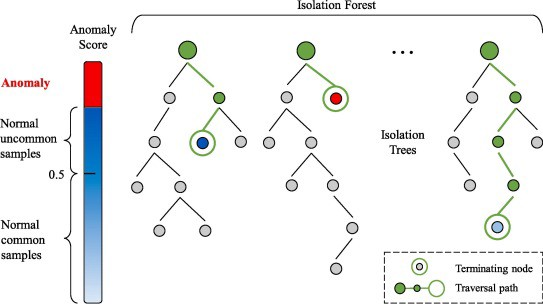

Below we will use the elbow method to choose what will be an ideal number of estimators to be used in the isolation forest model. The number of estimators refers to the number of trees that are used to construct the forest. The elbow method will be calculated based on the silhouette score, which takes as input the data points and the anomaly scores, and returns a score between -1 and 1 that measures how well the data points are separated into clusters by the model.

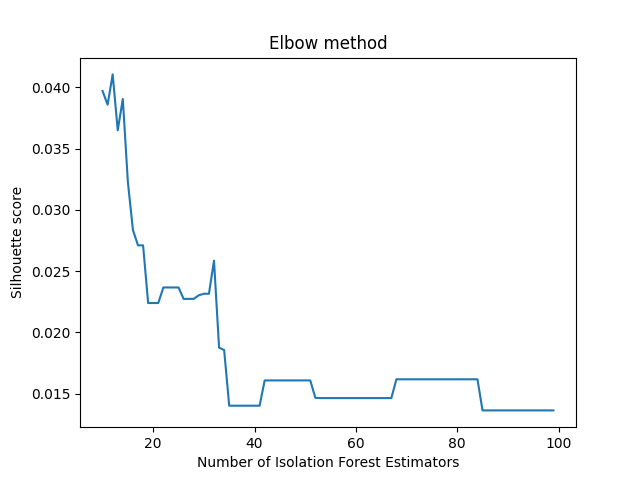

In [7]:
# import the necessary libraries
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_classification
from sklearn.metrics import silhouette_score

training_data = logs_summary.drop(['Log Name','Log Label'], axis=1) 
training_data = training_data[logs_summary['Log Label'] != "BAD"] 


# Define a range of values for the number of estimators
n_estimators_range = np.arange(10, 100, 1)

# Initialize an array to store the silhouette scores for each value of n_estimators
silhouette_scores = np.zeros(n_estimators_range.shape)

# Compute the silhouette score for each value of n_estimators
for i, n_estimators in enumerate(n_estimators_range):
    i_forest = IsolationForest(n_estimators=n_estimators, contamination='auto', random_state=0)
    i_forest.fit(training_data)
    anomaly_scores = i_forest.decision_function(training_data)
    silhouette_scores[i] = silhouette_score(training_data, anomaly_scores)

# Plot the silhouette scores as a function of n_estimators
plt.figure()
plt.plot(n_estimators_range, silhouette_scores)
plt.xlabel('Number of Isolation Forest Estimators')
plt.ylabel('Silhouette score')
plt.title('Elbow method')
plt.show()

After doing the elbow test, it was possible to observe that the ideal number of estimators for our dataset is around 40. So let's analyze what are the logs considered as outliers in this case:

Number of anomalies:  40


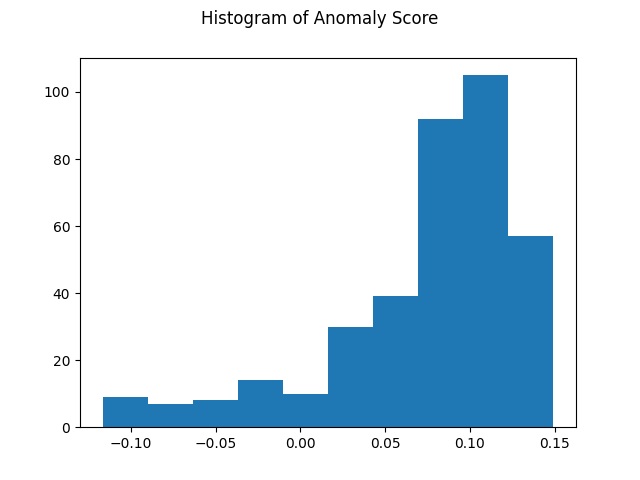

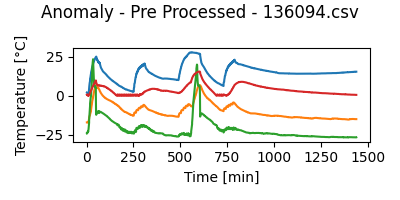

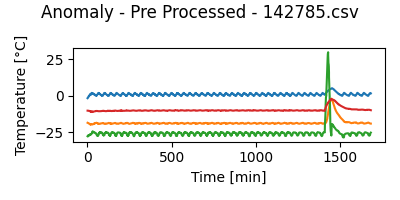

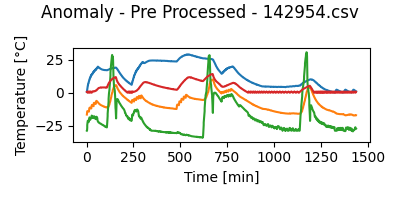

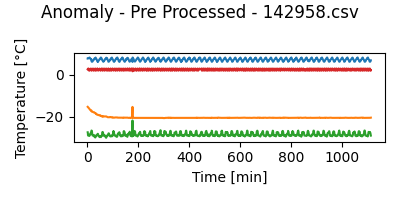

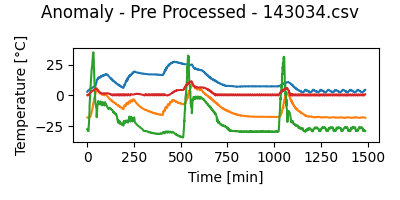

In [8]:
#Use the ideal number of estimators to create the optimal isolation forest
i_forest = IsolationForest(n_estimators=40, contamination='auto', random_state=0)
i_forest.fit(training_data)
pred = i_forest.predict(training_data)
pred_score = i_forest.decision_function(training_data)

#Organize the training data into anomaly and non anomaly
training_data['Is Anomaly'] = (pred == -1) 
training_data['Anomaly Score'] = pred_score
#Two possible ways here to consider anomalies, who has a very low score or who the model actually considered as anomaly
anomalies = training_data[training_data['Is Anomaly']  == True]
# anomalies = training_data[training_data['Anomaly Score']  < -0.1]

#Find the logs that are anomalies
logs_summary['Is Anomaly'] = False
logs_summary['Is Anomaly'].iloc[anomalies.index.to_list()] = True
anomalies = logs_summary[logs_summary['Is Anomaly']  == True]
print("Number of anomalies: ",len(anomalies))

#Plot the anomaly score
plt.figure()
plt.hist(pred_score)
plt.suptitle("Histogram of Anomaly Score")
plt.show()

#Plot up to 10 logs that were considered anomalies
for log_id,log_to_analyze in enumerate(anomalies['Log Name']):
    if(log_id < 5):
        RefriPlot_PlotTemperature(csv_files[log_to_analyze],"Anomaly - " + log_to_analyze, fig_size=(4,2))


#Actually dropping the anomaly column as it didn't seem to show good results
logs_summary.drop('Is Anomaly',axis=1,inplace=True)

With the upper approach of using isolation forest it was possible to perceive that the results were not good. The model is considering as anomalies some datasets that actually are not anomalies, it's not very clear why, but even by tuning different contamination rates (which are hard to define), the result was not very good.

Maybe for future approaches we might need to have more features built, data means increasing the number of vector features from our logs, maybe including more spectral related properties.

For now the isolation forest will not be further use to amplify our data.

***
## 4. Using Machine Learning Clustering methods

### 4.1 Clustering Theory

Clustering is the task of dividing the population or data points into a number of groups such that data points in the same groups are more similar to other data points in the same group and dissimilar to the data points in other groups.

For our case, the clustering algorithm will group logs that have similar characteristics. At an ideal scenario, there would be a cluster of FAULTY and another cluster of NON-FAULTY logs. But we will end up observing that actually the clusters that are formed show something else.

Below is the image of the typical representation of the K-means clustering algorithm:

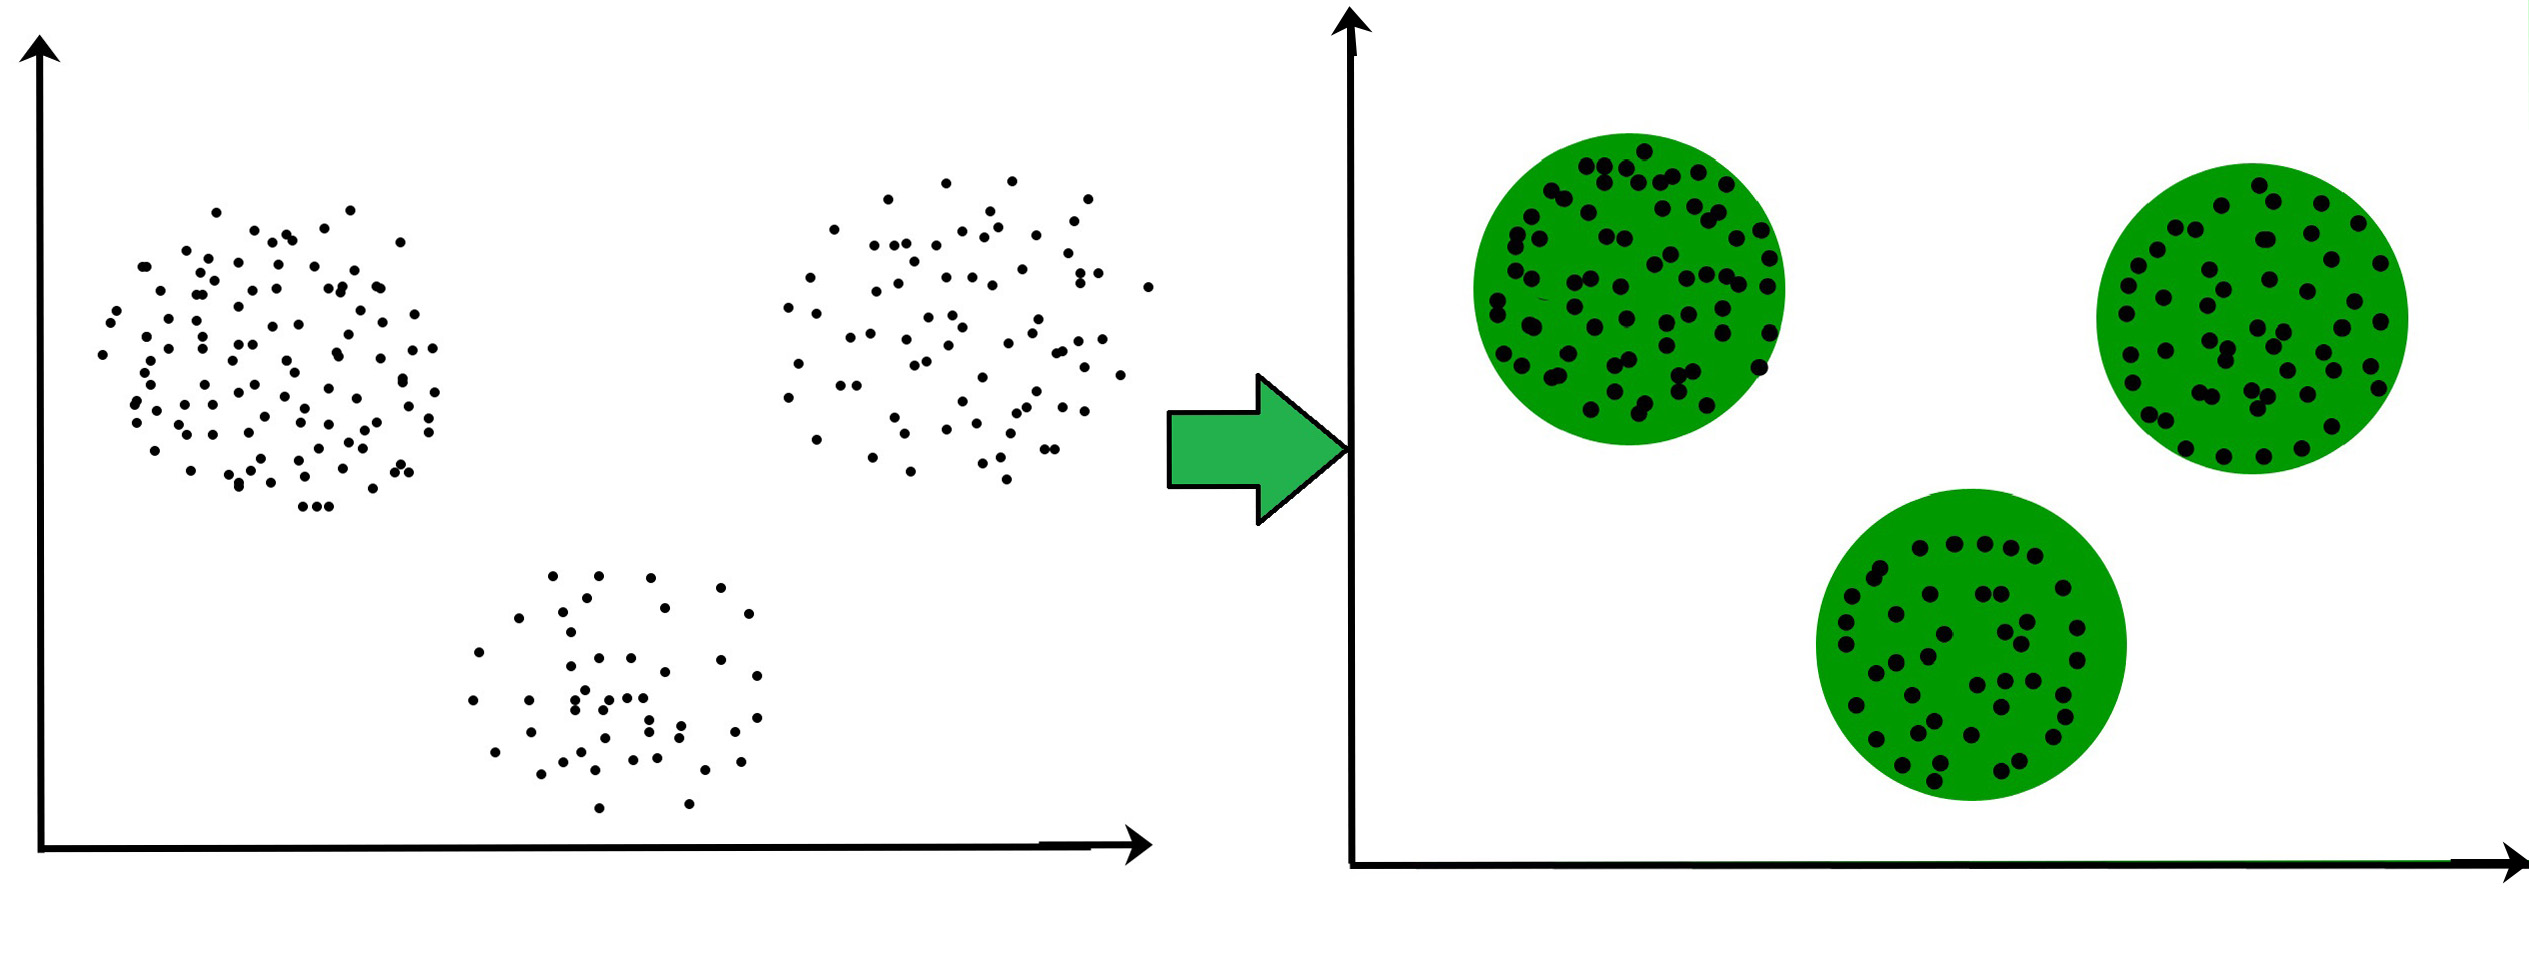

Just to highlight that clearly our problem at hand is not possible to be plotted like the image above, this is because our datapoints (our inputs) are time series and are not two dimensional only.


### 4.2 Modeling the problem of clustering temperature logs

The approach to model the problems that will be discussed was very similar to 3.3, where it was used the `logs_summary` data.


### 4.3 K-means Clustering

It is the simplest unsupervised learning algorithm that solves clustering problem. K-means algorithm partitions n observations into k clusters where each observation belongs to the cluster with the nearest mean serving as a prototype of the cluster. The algorithm is simple and iterative, by starting with N random clusters centers, classifying each data point to the closest cluster center, and then moving the center to the average of all the datapoints of that cluster, and then keep repeating the process.

K-means doesn't provide optimial results for handling outliers, as it try to fit even the outliers in a certain cluster which end up changing too much the cluster centers to a certain region. For that DBSCAN can work as good algorithm.

So first, let's choose the ideal number of clusters:

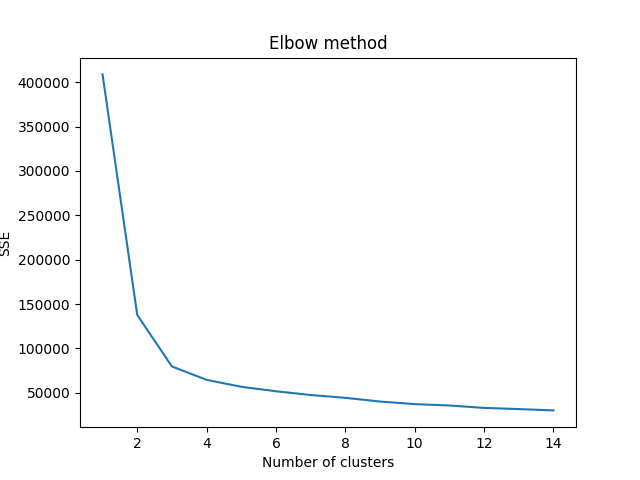

In [9]:
from sklearn.cluster import KMeans


#Remove first column as it's the log's name and label
training_data = logs_summary.drop(['Log Name','Log Label'], axis=1) 
#Remove the logs that we already know what they are
training_data = training_data[logs_summary['Log Label'] == "UNKNONW"] 


# Define the range of cluster numbers to test
k_range = range(1, 15)

# Initialize an empty list to store the SSE values for each k
sse = []

# Calculate SSE for each k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(training_data)
    sse.append(kmeans.inertia_)

# Plot SSE vs. k
plt.figure()
plt.plot(k_range, sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow method')
plt.show()

After doing the elbow test, it was possible to observe that the ideal number of clusters for our dataset is 3~4. So let's analyze what are those 4 clusters that were generated:

In [10]:
# Initialize k-means with N clusters
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(training_data)   

# Get the cluster assignments and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_


logs_summary["Cluster"] = "Others"
logs_summary["Cluster"].iloc[training_data.index.to_list()] = labels

print("Clusters:\n",logs_summary["Cluster"].value_counts())

Clusters:
 3         177
1         105
2          59
0          27
Others     16
Name: Cluster, dtype: int64


It was observed that the clusters created had a decent distribution, where we don't have any cluster with small amount of logs. That means the clustering had a decent result. But now let's analyze in more depth each one of the clusters

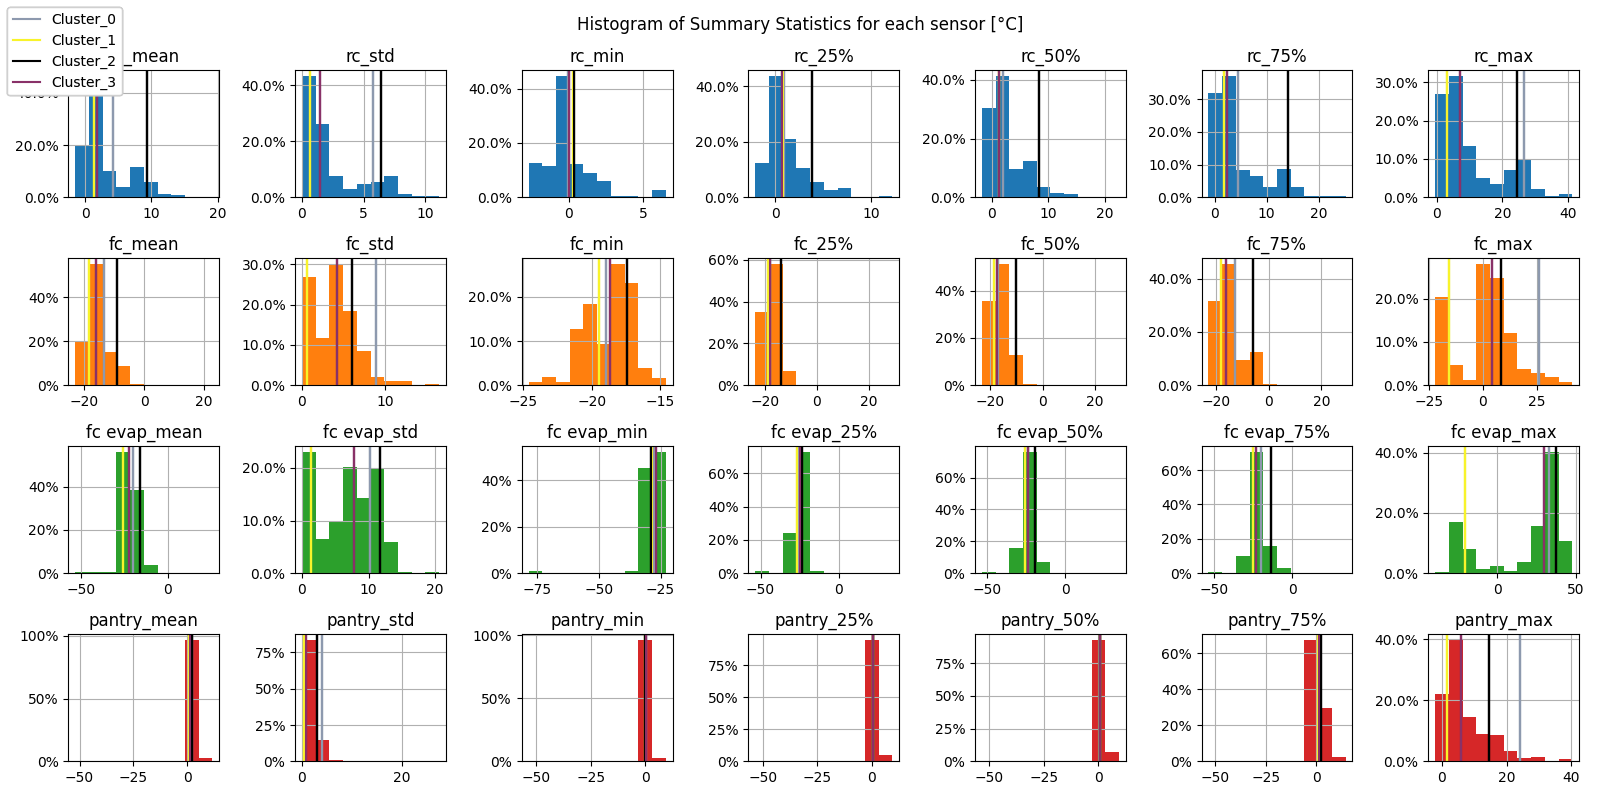

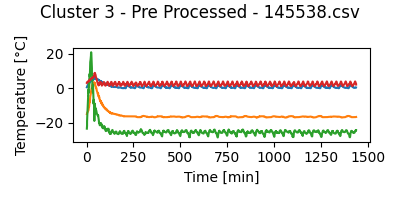

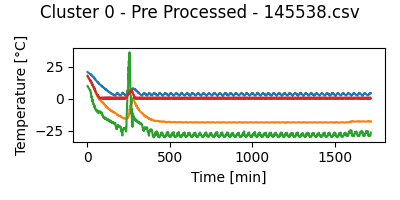

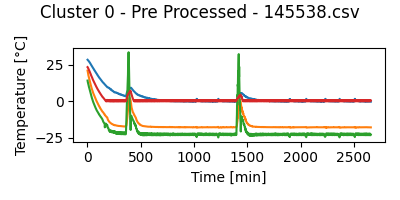

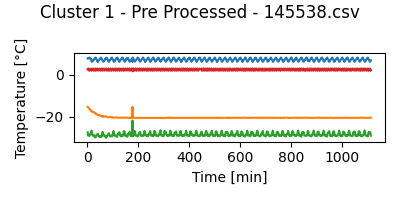

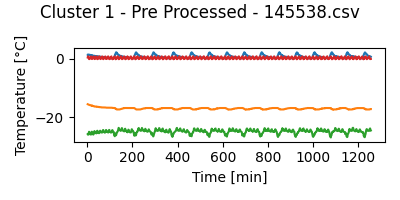

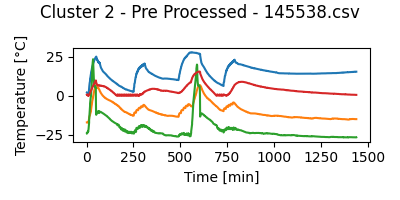

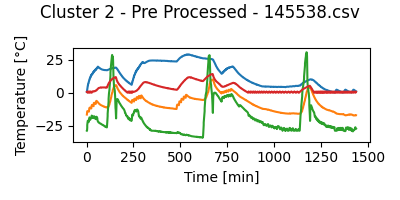

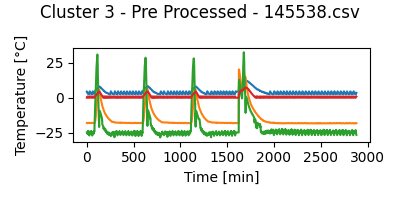

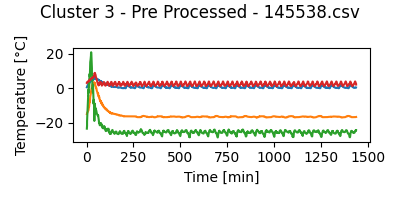

In [15]:
# Plot the centroid on the same histogram chart shown before
allaxes = fig_hist.get_axes()

centroids_colors = ["#8d99ae","#f8f32b","#000000","#893168","#4a1942","#2e1c2b"]
for centroid_id,centroid in enumerate(centroids):
    for val_id,centroid_val in enumerate(centroid):
        allaxes[val_id].axvline(x=centroid_val,color=centroids_colors[centroid_id])

cluster_names = ['Cluster_' + str(s) for s in range(0,len(centroids))]
fig_hist.legend(cluster_names, loc ='upper left')
fig_hist.show()
plt.show()


##Plot N logs of each cluster
LOGS_PER_CLUSTER = 2
for centroid_id,centroid in enumerate(centroids): 
    logs_on_cluster = logs_summary[logs_summary["Cluster"] == centroid_id]['Log Name']
    for log_id in range(0,LOGS_PER_CLUSTER):
        if(log_id < len(logs_on_cluster)):
            RefriPlot_PlotTemperature(csv_files[logs_on_cluster.iloc[log_id]],"Cluster "+str(centroid_id)+" - " + log_to_analyze, fig_size=(4,2))

### 4.4 DBSCAN Clustering

DBSCAN works by defining a neighborhood around each data point and grouping points that have a high density of neighbors into clusters.

DBSCAN identifies clusters based on the density of data points, rather than distance to a centroid, and it can handle datasets with arbitrary shapes and sizes. Data points that are not sufficiently close to any cluster are considered outliers and are not assigned to any cluster. Thus the algorithm identify regions of high density in the dataset and ignore isolated points that are far from any cluster.

In summary, k-means is a good option for datasets with well-separated clusters and a small number of clusters, while DBSCAN is better suited for datasets with an unknown number of clusters and clusters that are not well-separated or of irregular shapes.


The below image shows the difference between DBSCAN and K-Means

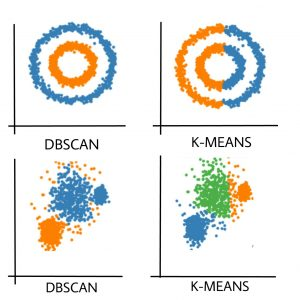


Below we will use DBSCAN to try a second way of clustering our datasets. On DBSCAN there are some critical hyperparameters, eps and min_samples, which determine the sensitivity of the algorithm to the distance between points and the minimum number of points required to form a cluster, respectively.

Grid search is a technique used in machine learning to find the best set of hyperparameters for a model. Grid search works by evaluating the performance of a model for different combinations of hyperparameters specified in a grid. In our case for DBSCAN we will be using it to tune 'eps' and 'min_samples'.

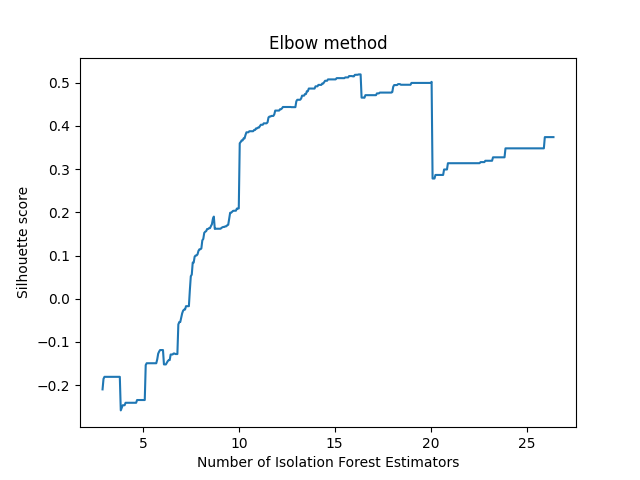

-1        320
1          26
0          22
Others     16
Name: DBSCAN_Cluster, dtype: int64


In [54]:
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV


eps_range = np.arange(0.05, 60, 0.05)

# Initialize an array to store the silhouette scores for each value of n_estimators
silhouette_scores = np.zeros(eps_range.shape)

# Compute the silhouette score for each value of n_estimators
for i, eps in enumerate(eps_range):
    dbscan = DBSCAN(min_samples=20,eps=eps)         #Considering a minimal valid 
    pred = dbscan.fit_predict(training_data)
    try:  
        silhouette_scores[i] = silhouette_score(training_data, pred)
    except:
        silhouette_scores[i] = None
    


# Plot the silhouette scores as a function of n_estimators
plt.figure()
plt.plot(eps_range, silhouette_scores)
plt.xlabel('Number of Isolation Forest Estimators')
plt.ylabel('Silhouette score')
plt.title('Elbow method')
plt.show()

-1        320
1          26
0          22
Others     16
Name: DBSCAN_Cluster, dtype: int64


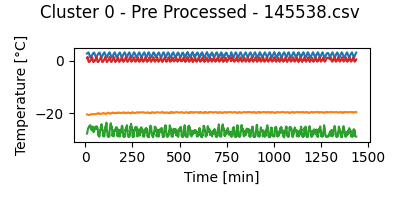

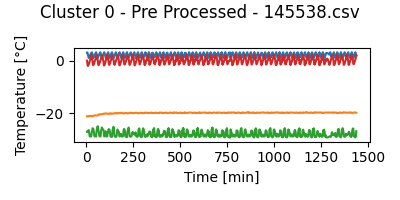

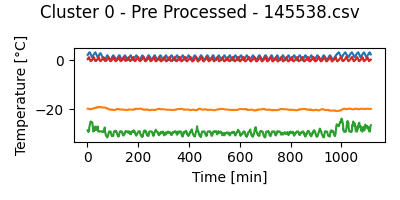

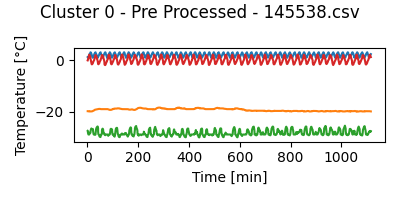

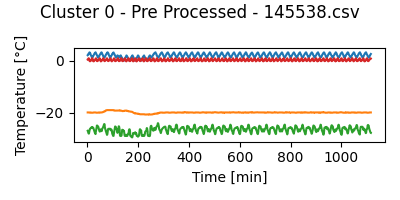

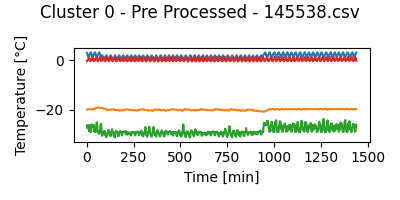

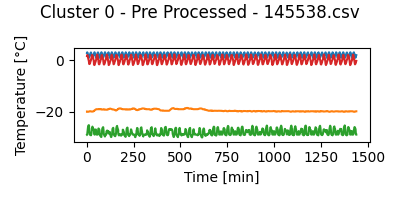

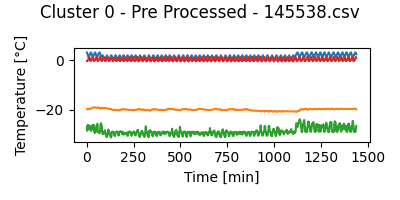

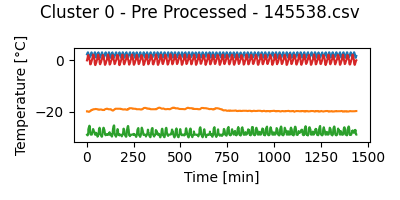

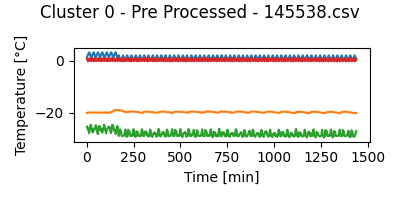

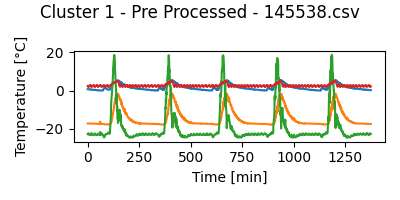

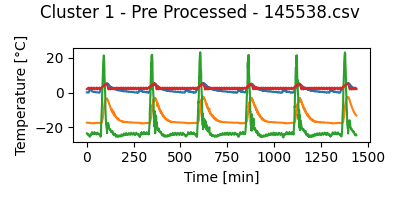

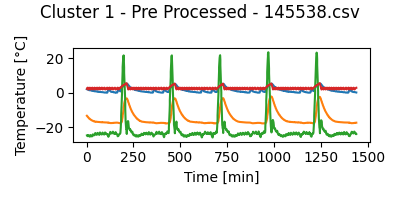

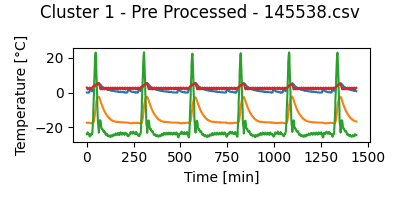

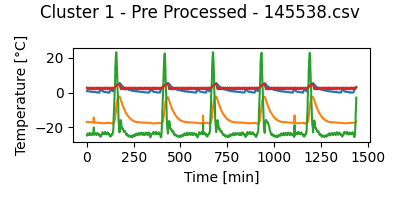

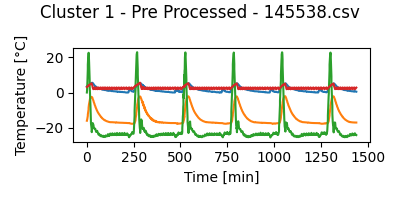

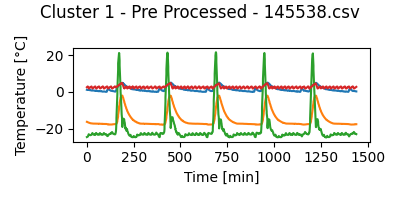

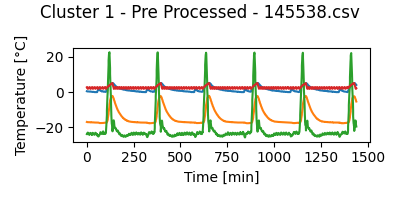

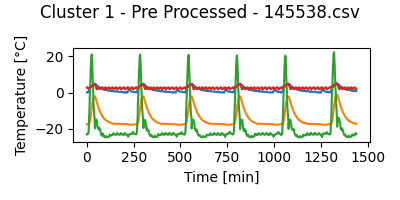

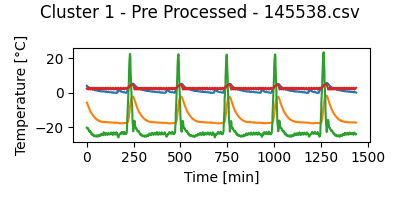

In [60]:
dbscan = DBSCAN(min_samples=20,eps=4)
pred = dbscan.fit_predict(training_data)

logs_summary["DBSCAN_Cluster"] = "Others"
logs_summary["DBSCAN_Cluster"].iloc[training_data.index.to_list()] = pred

print(logs_summary["DBSCAN_Cluster"].value_counts())

##Plot N logs of each cluster
LOGS_PER_CLUSTER = 10
for cluster_id in np.unique(pred): 
    logs_on_cluster = logs_summary[logs_summary["DBSCAN_Cluster"] == cluster_id]['Log Name']
    for log_id in range(0,LOGS_PER_CLUSTER):
        if(log_id < len(logs_on_cluster) and cluster_id >= 0):
            RefriPlot_PlotTemperature(csv_files[logs_on_cluster.iloc[log_id]],"Cluster "+str(cluster_id)+" - " + log_to_analyze, fig_size=(4,2))